## Time series task typology

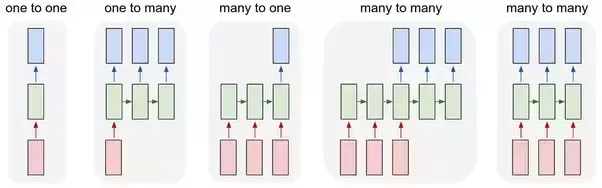

In [2]:
from IPython.display import Image
Image(filename='imgs/lstm-types.jpg', width=800)

- Each rectangle is a vector 
-  arrows represent functions (e.g. matrix multiply). 
- Input vectors are in red
- Output vectors are in blue
- Green vectors hold the RNN's state (more on this soon). 

### **Input data**

must **always** be of shape `[nb_samples, nb_timesteps_in, nb_features_in]`

- if `nb_features`>1 then we are dealing about multisignal time series

### Task typology

**one-to-one**: From fixed-sized input to fixed-sized output (e.g. image classification).
- **input_data**: `[nb_samples, 1, nb_features_in]`
- **output_data**: `[nb_samples, nb_features_out]`

**one-to-many**: Sequence output (e.g. image captioning takes an iFage and outputs a sentence of words). 
- **input_data**: `[nb_samples, 1, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`

**many-to-one**: Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment).
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_features_out]`

**many-to-many**: Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French). 
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`

**many-to-many**: Synced sequence input and output (e.g. video classification where we wish to label each frame of the video). Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`



## Original signal

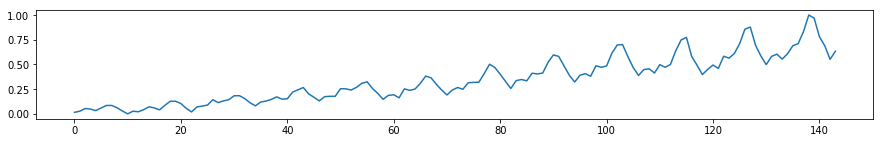

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

dataset = pd.read_csv('data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.figure(figsize=(15,2))
plt.plot(dataset)


## Timeseries dataset creation

In [343]:
def timeseries_as_one2one(t, timelag=1):
    assert timelag>0, "timelag must be >0"
    X = t[:-timelag].reshape(-1,1,1)
    y = t[timelag:].reshape(-1,1)
    return X,y

def timeseries_as_many2one(t, nb_timesteps_in, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1])
    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,1)

def timeseries_as_many2many(t, nb_timesteps_in, nb_timesteps_out, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag-nb_timesteps_out):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1:i+nb_timesteps_in+timelag-1+nb_timesteps_out])

    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,nb_timesteps_out,1)


### one2one

In [344]:
X,y = timeseries_as_one2one(dataset, timelag=1)
print "Xy shapes", X.shape, y.shape
print "original signal", dataset[:10].flatten()
print "input data"
for i in range(3):
    print X[i].flatten()
print "output data", y[:3].flatten()

Xy shapes (143, 1, 1) (143, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401]
[0.02702703]
[0.05405405]
output data [0.02702703 0.05405405 0.04826255]


### many2one

In [345]:
X,y = timeseries_as_many2one(dataset, nb_timesteps_in=4, timelag=1)
print "Xy shapes", X.shape, y.shape
print "original signal", dataset[:10].flatten()
print "input data"
for i in range(3):
    print X[i].flatten()
print "output data", y[:3].flatten()

Xy shapes (139, 4, 1) (139, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401 0.02702703 0.05405405 0.04826255]
[0.02702703 0.05405405 0.04826255 0.03281853]
[0.05405405 0.04826255 0.03281853 0.05984557]
output data [0.03281853 0.05984557 0.08494207]


### many2many

In [346]:
X,y = timeseries_as_many2many(dataset, nb_timesteps_in=4, nb_timesteps_out=2, timelag=1)
print "Xy shapes", X.shape, y.shape
print "original signal", dataset[:10].flatten()
print "input data"
for i in range(3):
    print X[i].flatten()
print "output data"
for i in range(3):
    print y[i].flatten()


Xy shapes (137, 4, 1) (137, 2, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401 0.02702703 0.05405405 0.04826255]
[0.02702703 0.05405405 0.04826255 0.03281853]
[0.05405405 0.04826255 0.03281853 0.05984557]
output data
[0.03281853 0.05984557]
[0.05984557 0.08494207]
[0.08494207 0.08494207]


# LSTMs

## for one2one

In [166]:
X,y = timeseries_as_one2one(dataset, timelag=1)
X.shape, y.shape

((143, 1, 1), (143, 1))

In [167]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((95, 1, 1), (48, 1, 1), (95, 1), (48, 1))

In [168]:
def get_one2one_single_layer_LSTM(n_neurons):
    # create LSTM
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(1, 1), recurrent_activation="sigmoid"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mape"])
    return model

In [169]:
model = get_one2one_single_layer_LSTM(n_neurons=10)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [174]:
model.fit(Xtr, ytr, epochs=150, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 95 samples, validate on 48 samples
Epoch 1/150
95/95 [==============================] - 0s 545us/step - loss: 0.0110 - mean_absolute_percentage_error: 1852488.9746 - val_loss: 0.0887 - val_mean_absolute_percentage_error: 43.8290
Epoch 2/150
95/95 [==============================] - 0s 534us/step - loss: 0.0107 - mean_absolute_percentage_error: 1841109.8921 - val_loss: 0.0845 - val_mean_absolute_percentage_error: 42.6353
Epoch 3/150
95/95 [==============================] - 0s 552us/step - loss: 0.0104 - mean_absolute_percentage_error: 1837645.9497 - val_loss: 0.0809 - val_mean_absolute_percentage_error: 41.5935
Epoch 4/150
95/95 [==============================] - 0s 603us/step - loss: 0.0101 - mean_absolute_percentage_error: 1823800.3633 - val_loss: 0.0778 - val_mean_absolute_percentage_error: 40.7110
Epoch 5/150
95/95 [==============================] - 0s 548us/step - loss: 0.0098 - mean_absolute_percentage_error: 1800021.8390 - val_loss: 0.0750 - val_mean_absolute_percentage_e

95/95 [==============================] - 0s 581us/step - loss: 0.0022 - mean_absolute_percentage_error: 696150.2733 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 13.6186
Epoch 43/150
95/95 [==============================] - 0s 545us/step - loss: 0.0022 - mean_absolute_percentage_error: 681901.7247 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 13.5329
Epoch 44/150
95/95 [==============================] - 0s 535us/step - loss: 0.0021 - mean_absolute_percentage_error: 685293.2501 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 13.3384
Epoch 45/150
95/95 [==============================] - 0s 563us/step - loss: 0.0021 - mean_absolute_percentage_error: 684681.2101 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.2450
Epoch 46/150
95/95 [==============================] - 0s 573us/step - loss: 0.0021 - mean_absolute_percentage_error: 660002.2132 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.2829
Epoch 47/150
95/95 [=======================

95/95 [==============================] - 0s 542us/step - loss: 0.0020 - mean_absolute_percentage_error: 529164.3920 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 13.0147
Epoch 85/150
95/95 [==============================] - 0s 529us/step - loss: 0.0020 - mean_absolute_percentage_error: 525187.6575 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 12.9906
Epoch 86/150
95/95 [==============================] - 0s 889us/step - loss: 0.0020 - mean_absolute_percentage_error: 532604.3127 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 13.0065
Epoch 87/150
95/95 [==============================] - 0s 832us/step - loss: 0.0020 - mean_absolute_percentage_error: 525958.5014 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 13.0570
Epoch 88/150
95/95 [==============================] - 0s 831us/step - loss: 0.0020 - mean_absolute_percentage_error: 493246.5956 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 13.0629
Epoch 89/150
95/95 [=======================

Epoch 126/150
95/95 [==============================] - 0s 587us/step - loss: 0.0020 - mean_absolute_percentage_error: 503904.5728 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 12.9525
Epoch 127/150
95/95 [==============================] - 0s 954us/step - loss: 0.0020 - mean_absolute_percentage_error: 510098.3448 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 13.0032
Epoch 128/150
95/95 [==============================] - 0s 896us/step - loss: 0.0020 - mean_absolute_percentage_error: 527801.1611 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 12.9162
Epoch 129/150
95/95 [==============================] - 0s 913us/step - loss: 0.0020 - mean_absolute_percentage_error: 533144.8627 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 12.9238
Epoch 130/150
95/95 [==============================] - 0s 626us/step - loss: 0.0020 - mean_absolute_percentage_error: 512422.4929 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 12.9616
Epoch 131/150
95/95 [====

In [175]:
yts_preds = model.predict(Xts)
print "trend accuracy %.2f"%(np.mean( (yts_preds[1:]>yts_preds[:-1])==(yts[1:]>yts[:-1])))
yts_preds.shape

trend accuracy 0.53


(48, 1)

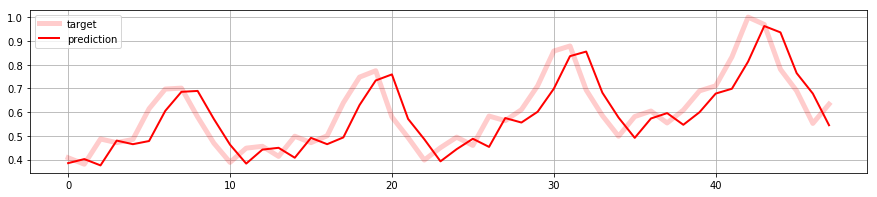

In [176]:
plt.figure(figsize=(15,3))
plt.plot(yts[:,0], color="red", alpha=.2, lw=5, label="target")
plt.plot(yts_preds[:,0], color="red", alpha=1, lw=2, label="prediction")
plt.legend()
plt.grid()

## For many2one

In [236]:
X,y = timeseries_as_many2one(dataset, nb_timesteps_in=20, timelag=1)
X.shape, y.shape

((123, 20, 1), (123, 1))

In [237]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((82, 20, 1), (41, 20, 1), (82, 1), (41, 1))

In [238]:
def get_many2one_single_layer_LSTM(n_neurons, nb_timesteps_in):
    # create LSTM
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(nb_timesteps_in, 1),recurrent_activation="sigmoid"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mape"])
    return model

In [239]:
model = get_many2one_single_layer_LSTM(n_neurons=30, nb_timesteps_in=X.shape[1])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
None


In [240]:
model.fit(Xtr, ytr, epochs=150, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 82 samples, validate on 41 samples
Epoch 1/150
82/82 [==============================] - 2s 21ms/step - loss: 0.1171 - mean_absolute_percentage_error: 109.6007 - val_loss: 0.3640 - val_mean_absolute_percentage_error: 94.2505
Epoch 2/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0470 - mean_absolute_percentage_error: 64.0326 - val_loss: 0.1450 - val_mean_absolute_percentage_error: 54.3234
Epoch 3/150
82/82 [==============================] - 0s 2ms/step - loss: 0.0131 - mean_absolute_percentage_error: 45.4202 - val_loss: 0.0322 - val_mean_absolute_percentage_error: 19.0863
Epoch 4/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0117 - mean_absolute_percentage_error: 66.0063 - val_loss: 0.0329 - val_mean_absolute_percentage_error: 19.1880
Epoch 5/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 47.0013 - val_loss: 0.0533 - val_mean_absolute_percentage_error: 25.7654
Epoch 6/150
82/82 [

82/82 [==============================] - 0s 3ms/step - loss: 0.0049 - mean_absolute_percentage_error: 27.2564 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 18.9856
Epoch 45/150
82/82 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_absolute_percentage_error: 28.0360 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 17.6364
Epoch 46/150
82/82 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_absolute_percentage_error: 27.4052 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 17.5891
Epoch 47/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0046 - mean_absolute_percentage_error: 27.5543 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 18.2562
Epoch 48/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0045 - mean_absolute_percentage_error: 27.7388 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 17.7857
Epoch 49/150
82/82 [==============================] - 0s 4ms/step - loss:

Epoch 88/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_absolute_percentage_error: 23.2343 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 15.2894
Epoch 89/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_absolute_percentage_error: 23.4596 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 16.1461
Epoch 90/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_absolute_percentage_error: 24.9882 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 16.5111
Epoch 91/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_absolute_percentage_error: 23.9613 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 15.8144
Epoch 92/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_absolute_percentage_error: 25.6374 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 17.0460
Epoch 93/150
82/82 [==============================] - 0s 4ms

82/82 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_percentage_error: 17.7224 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 10.9508
Epoch 132/150
82/82 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_absolute_percentage_error: 16.9457 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 10.9386
Epoch 133/150
82/82 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_percentage_error: 18.2233 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 10.7794
Epoch 134/150
82/82 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_percentage_error: 18.3504 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 10.8037
Epoch 135/150
82/82 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_percentage_error: 16.5142 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 10.8560
Epoch 136/150
82/82 [==============================] - 0s 2ms/step - 

In [241]:
yts_preds = model.predict(Xts)
yts_preds.shape
print "trend accuracy %.2f"%(np.mean( (yts_preds[1:]>yts_preds[:-1])==(yts[1:]>yts[:-1])))

trend accuracy 0.75


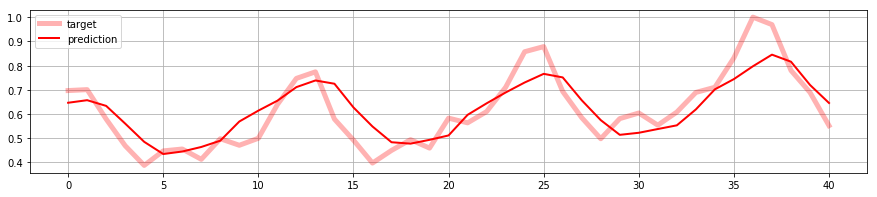

In [242]:
plt.figure(figsize=(15,3))
plt.plot(yts[:,0], color="red", alpha=.3, lw=5, label="target")
plt.plot(yts_preds[:,0], color="red", alpha=1, lw=2, label="prediction")
plt.legend()
plt.grid()

## For many2many

In [338]:
def timeseries_as_many2many(t, nb_timesteps_in, nb_timesteps_out, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag-nb_timesteps_out):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1:i+nb_timesteps_in+timelag-1+nb_timesteps_out])

    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,nb_timesteps_out)




((103, 20, 1), (103, 20))

In [395]:
X,y = timeseries_as_many2many(dataset, nb_timesteps_in=20, nb_timesteps_out=20, timelag=1)
X.shape, y.shape

((103, 20, 1), (103, 20, 1))

In [396]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((68, 20, 1), (35, 20, 1), (68, 20, 1), (35, 20, 1))

In [400]:
def get_many2many_single_layer_LSTM(n_neurons, nb_timesteps_in, nb_timesteps_out):
    # create LSTM
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(nb_timesteps_in, 1), 
                   recurrent_activation="sigmoid", return_sequences=True))
    model.add(TimeDistributed(Dense(500)))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mape"])
    return model

In [401]:
model = get_many2many_single_layer_LSTM(n_neurons=200, nb_timesteps_in=X.shape[1], nb_timesteps_out=y.shape[1])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 200)           161600    
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 500)           100500    
_________________________________________________________________
dense_1 (Dense)              (None, 20, 10)            5010      
_________________________________________________________________
dense_2 (Dense)              (None, 20, 1)             11        
Total params: 267,121
Trainable params: 267,121
Non-trainable params: 0
_________________________________________________________________
None


In [402]:
model.fit(Xtr, ytr, epochs=300, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 68 samples, validate on 35 samples
Epoch 1/300
68/68 [==============================] - 3s 43ms/step - loss: 0.0267 - mean_absolute_percentage_error: 52.5284 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 19.3188
Epoch 2/300
68/68 [==============================] - 1s 13ms/step - loss: 0.0097 - mean_absolute_percentage_error: 26.1364 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 19.0659
Epoch 3/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0076 - mean_absolute_percentage_error: 34.1287 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 19.2115
Epoch 4/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_absolute_percentage_error: 24.8785 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 20.0785
Epoch 5/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_absolute_percentage_error: 29.2249 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 24.0392
Epoch 6/300
68/6

68/68 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_absolute_percentage_error: 21.4853 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 22.5527
Epoch 45/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_absolute_percentage_error: 21.1556 - val_loss: 0.0354 - val_mean_absolute_percentage_error: 28.2163
Epoch 46/300
68/68 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_absolute_percentage_error: 21.4812 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 20.7201
Epoch 47/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_absolute_percentage_error: 21.7448 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 23.1484
Epoch 48/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_absolute_percentage_error: 21.5560 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 25.1925
Epoch 49/300
68/68 [==============================] - 1s 11ms/step -

68/68 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_absolute_percentage_error: 20.5503 - val_loss: 0.0654 - val_mean_absolute_percentage_error: 38.3799
Epoch 88/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_absolute_percentage_error: 20.9411 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 27.1390
Epoch 89/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_absolute_percentage_error: 21.0506 - val_loss: 0.0465 - val_mean_absolute_percentage_error: 30.9957
Epoch 90/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_absolute_percentage_error: 21.3898 - val_loss: 0.0365 - val_mean_absolute_percentage_error: 26.8138
Epoch 91/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_absolute_percentage_error: 20.8757 - val_loss: 0.0391 - val_mean_absolute_percentage_error: 27.7290
Epoch 92/300
68/68 [==============================] - 1s 12ms/step -

68/68 [==============================] - 1s 16ms/step - loss: 0.0025 - mean_absolute_percentage_error: 18.6308 - val_loss: 0.1153 - val_mean_absolute_percentage_error: 46.8008
Epoch 131/300
68/68 [==============================] - 1s 17ms/step - loss: 0.0025 - mean_absolute_percentage_error: 18.3981 - val_loss: 0.1093 - val_mean_absolute_percentage_error: 44.5606
Epoch 132/300
68/68 [==============================] - 1s 14ms/step - loss: 0.0025 - mean_absolute_percentage_error: 19.0212 - val_loss: 0.1210 - val_mean_absolute_percentage_error: 47.0610
Epoch 133/300
68/68 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_absolute_percentage_error: 18.9532 - val_loss: 0.1083 - val_mean_absolute_percentage_error: 44.2240
Epoch 134/300
68/68 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_absolute_percentage_error: 18.5061 - val_loss: 0.1050 - val_mean_absolute_percentage_error: 43.5721
Epoch 135/300
68/68 [==============================] - 1s 15ms/s

68/68 [==============================] - 1s 12ms/step - loss: 0.0022 - mean_absolute_percentage_error: 17.3677 - val_loss: 0.0852 - val_mean_absolute_percentage_error: 39.0329
Epoch 174/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0022 - mean_absolute_percentage_error: 17.1812 - val_loss: 0.0866 - val_mean_absolute_percentage_error: 39.4479
Epoch 175/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0023 - mean_absolute_percentage_error: 17.6446 - val_loss: 0.1083 - val_mean_absolute_percentage_error: 45.1464
Epoch 176/300
68/68 [==============================] - 1s 11ms/step - loss: 0.0025 - mean_absolute_percentage_error: 17.8287 - val_loss: 0.1001 - val_mean_absolute_percentage_error: 43.2240
Epoch 177/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0022 - mean_absolute_percentage_error: 17.1793 - val_loss: 0.0924 - val_mean_absolute_percentage_error: 40.3949
Epoch 178/300
68/68 [==============================] - 1s 15ms/s

68/68 [==============================] - 1s 12ms/step - loss: 0.0021 - mean_absolute_percentage_error: 16.5371 - val_loss: 0.0668 - val_mean_absolute_percentage_error: 36.3020
Epoch 217/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0020 - mean_absolute_percentage_error: 15.8037 - val_loss: 0.0560 - val_mean_absolute_percentage_error: 32.2833
Epoch 218/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0020 - mean_absolute_percentage_error: 15.8480 - val_loss: 0.0637 - val_mean_absolute_percentage_error: 35.2059
Epoch 219/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0020 - mean_absolute_percentage_error: 16.1391 - val_loss: 0.0592 - val_mean_absolute_percentage_error: 33.9491
Epoch 220/300
68/68 [==============================] - 1s 18ms/step - loss: 0.0020 - mean_absolute_percentage_error: 15.7113 - val_loss: 0.0559 - val_mean_absolute_percentage_error: 32.4086
Epoch 221/300
68/68 [==============================] - 1s 16ms/s

68/68 [==============================] - 1s 12ms/step - loss: 0.0019 - mean_absolute_percentage_error: 14.9541 - val_loss: 0.0320 - val_mean_absolute_percentage_error: 25.7897
Epoch 260/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0020 - mean_absolute_percentage_error: 16.0289 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 25.2680
Epoch 261/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0019 - mean_absolute_percentage_error: 15.8472 - val_loss: 0.0340 - val_mean_absolute_percentage_error: 25.4927
Epoch 262/300
68/68 [==============================] - 1s 12ms/step - loss: 0.0019 - mean_absolute_percentage_error: 14.6855 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 25.1271
Epoch 263/300
68/68 [==============================] - 1s 11ms/step - loss: 0.0018 - mean_absolute_percentage_error: 15.3225 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 22.7340
Epoch 264/300
68/68 [==============================] - 1s 12ms/s

In [391]:
yts_preds = model.predict(Xts)
print yts_preds.shape
print "trend accuracy %.2f"%(np.mean( (yts_preds[1:]>yts_preds[:-1])==(yts[1:]>yts[:-1])))

(28, 30, 1)
trend accuracy 0.73


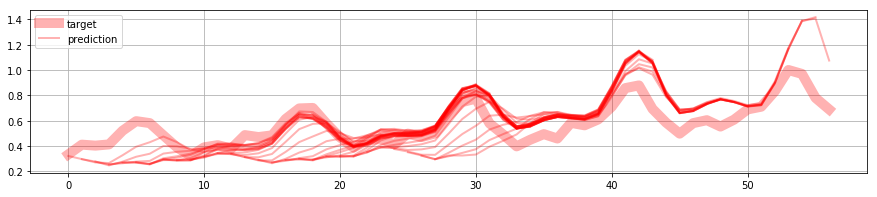

In [392]:
plt.figure(figsize=(15,3))

k = np.r_[[0.]*(yts.shape[0]+yts.shape[1]-1)]
k[:yts.shape[0]] = yts[:,0,0]
k[-yts.shape[1]+1:] = yts[-1,1:,0]
plt.plot(k, color="red", alpha=.3, lw=10, label="target")

for i in range(len(yts_preds)):
    plt.plot(range(i,i+yts.shape[1]), yts_preds[i,:,0], color="red", alpha=.3, lw=2, label="prediction" if i==0 else None)

plt.legend()
plt.grid()

In [393]:
ytr_preds = model.predict(Xtr)
print ytr_preds.shape
print "trend accuracy %.2f"%(np.mean( (ytr_preds[1:]>ytr_preds[:-1])==(ytr[1:]>ytr[:-1])))

(55, 30, 1)
trend accuracy 0.74


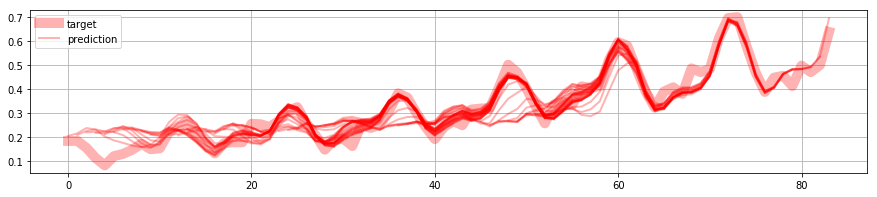

In [394]:
plt.figure(figsize=(15,3))

k = np.r_[[0.]*(ytr.shape[0]+ytr.shape[1]-1)]
k[:ytr.shape[0]] = ytr[:,0,0]
k[-ytr.shape[1]+1:] = ytr[-1,1:,0]
plt.plot(k, color="red", alpha=.3, lw=10, label="target")

for i in range(len(ytr_preds)):
    plt.plot(range(i,i+ytr.shape[1]), ytr_preds[i,:,0], color="red", alpha=.3, lw=2, label="prediction" if i==0 else None)

plt.legend()
plt.grid()

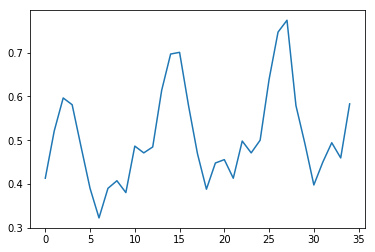

In [294]:
plt.plot(list(yts[:,0,0])+yts[]

In [300]:
print yts[0,:,0]
print yts[1,:,0]


[0.4131274  0.52123547 0.5965251  0.58108103 0.484556   0.3899614
 0.3223938  0.3899614  0.4073359  0.3803089  0.48648646 0.47104248
 0.484556   0.6138996  0.6969112  0.70077217 0.57915056 0.46911195
 0.38803086 0.44787642]
[0.52123547 0.5965251  0.58108103 0.484556   0.3899614  0.3223938
 0.3899614  0.4073359  0.3803089  0.48648646 0.47104248 0.484556
 0.6138996  0.6969112  0.70077217 0.57915056 0.46911195 0.38803086
 0.44787642 0.45559844]


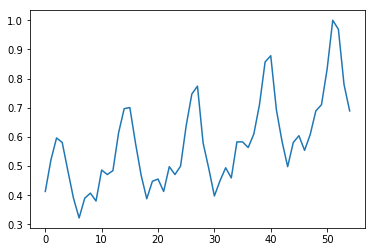

In [316]:
k = np.r_[[0.]*(yts.shape[0]+yts.shape[1])]
k[:yts.shape[0]] = yts[:,0,0]
k[-yts.shape[1]:] = yts[-1,:,0]
plt.plot(k)

In [315]:
k1 = yts[:,0,0]
k2 = yts[0,:,0]
k1, k2

(array([0.4131274 , 0.52123547, 0.5965251 , 0.58108103, 0.484556  ,
        0.3899614 , 0.3223938 , 0.3899614 , 0.4073359 , 0.3803089 ,
        0.48648646, 0.47104248, 0.484556  , 0.6138996 , 0.6969112 ,
        0.70077217, 0.57915056, 0.46911195, 0.38803086, 0.44787642,
        0.45559844, 0.4131274 , 0.4980695 , 0.47104248, 0.49999997,
        0.6389961 , 0.7471043 , 0.7741313 , 0.57915056, 0.492278  ,
        0.3976834 , 0.44980696, 0.49420848, 0.45945945, 0.5830116 ],
       dtype=float32),
 array([0.4131274 , 0.52123547, 0.5965251 , 0.58108103, 0.484556  ,
        0.3899614 , 0.3223938 , 0.3899614 , 0.4073359 , 0.3803089 ,
        0.48648646, 0.47104248, 0.484556  , 0.6138996 , 0.6969112 ,
        0.70077217, 0.57915056, 0.46911195, 0.38803086, 0.44787642],
       dtype=float32))

In [310]:
yts[:,0,0]

array([0.4131274 , 0.52123547, 0.5965251 , 0.58108103, 0.484556  ,
       0.3899614 , 0.3223938 , 0.3899614 , 0.4073359 , 0.3803089 ,
       0.48648646, 0.47104248, 0.484556  , 0.6138996 , 0.6969112 ,
       0.70077217, 0.57915056, 0.46911195, 0.38803086, 0.44787642,
       0.45559844, 0.4131274 , 0.4980695 , 0.47104248, 0.49999997,
       0.6389961 , 0.7471043 , 0.7741313 , 0.57915056, 0.492278  ,
       0.3976834 , 0.44980696, 0.49420848, 0.45945945, 0.5830116 ],
      dtype=float32)

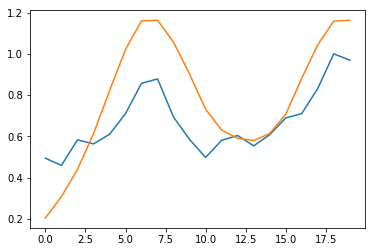

In [282]:
i = np.random.randint(len(yts))
plt.plot(yts[i])
plt.plot(yts_preds[i])

In [286]:
yts_preds[:,3]

array([[0.33873725],
       [0.31226796],
       [0.31424856],
       [0.33522242],
       [0.34964013],
       [0.36400366],
       [0.38781768],
       [0.40412766],
       [0.4493202 ],
       [0.50781476],
       [0.522975  ],
       [0.4754266 ],
       [0.41204792],
       [0.37696797],
       [0.37803996],
       [0.40670103],
       [0.42042315],
       [0.43840307],
       [0.46488535],
       [0.48381406],
       [0.5370342 ],
       [0.604464  ],
       [0.6142909 ],
       [0.55828726],
       [0.47407925],
       [0.4285211 ],
       [0.42849255],
       [0.4527459 ],
       [0.47007912],
       [0.49133652],
       [0.52722263],
       [0.54835004],
       [0.6123623 ],
       [0.6978381 ],
       [0.7149745 ]], dtype=float32)

In [117]:
yts.shape

(48, 1)

In [20]:

from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(len(seq), 1, 1)
y = seq.reshape(len(seq), 1)
# define LSTM configuration
n_neurons = 10
n_batch = length
n_epoch = 10
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result:
    print('%.3f' % value)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
 - 2s - loss: 0.2062
Epoch 2/10
 - 0s - loss: 0.2043
Epoch 3/10
 - 0s - loss: 0.2024
Epoch 4/10
 - 0s - loss: 0.2005
Epoch 5/10
 - 0s - loss: 0.1986
Epoch 6/10
 - 0s - loss: 0.1967
Epoch 7/10
 - 0s - loss: 0.1948
Epoch 8/10
 - 0s - loss: 0.1929
Epoch 9/10
 - 0s - loss: 0.1911
Epoch 10/10
 - 0s - loss: 0.1892
0.018
0.036
0.054
0.070
0.086


In [17]:
X.shape

(5, 1, 1)

In [18]:
y.shape

(5, 1)

In [15]:
X, y

(array([[[0. ]],
 
        [[0.2]],
 
        [[0.4]],
 
        [[0.6]],
 
        [[0.8]]]), array([[0. ],
        [0.2],
        [0.4],
        [0.6],
        [0.8]]))

In [19]:
model.predict(X[:2])

array([[0.01350248],
       [0.00598433]], dtype=float32)

In [23]:
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length)
# define LSTM configuration
n_neurons = length
n_batch = 1
n_epoch = 100
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1)))
model.add(Dense(length))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result[0,:]:
	print('%.1f' % value)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 30        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 - 2s - loss: 0.2209
Epoch 2/100
 - 0s - loss: 0.2191
Epoch 3/100
 - 0s - loss: 0.2173
Epoch 4/100
 - 0s - loss: 0.2156
Epoch 5/100
 - 0s - loss: 0.2138
Epoch 6/100
 - 0s - loss: 0.2121
Epoch 7/100
 - 0s - loss: 0.2103
Epoch 8/100
 - 0s - loss: 0.2086
Epoch 9/100
 - 0s - loss: 0.2069
Epoch 10/100
 - 0s - loss: 0.2052
Epoch 11/100
 - 0s - loss: 0.2035
Epoch 12/100
 - 0s - loss: 0.2018
Epoch 13/100
 - 0s - loss: 0.2001
Epoch 14/100
 - 0s - loss: 0.1985
Epoch 15/100
 - 0s - loss: 0.1968
Epoch 16/100
 - 0s - loss: 0.1952


In [24]:
X

array([[[0. ],
        [0.2],
        [0.4],
        [0.6],
        [0.8]]])

In [27]:
y

array([[0. , 0.2, 0.4, 0.6, 0.8]])